In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import statsmodels.formula.api as smf
import seaborn as sns
import random
from matplotlib.patches import Patch

%matplotlib inline

In [ ]:
# Einlesen der Grundwasser-Messdaten im Pickle-Format
df_ms_ws_input = pd.read_pickle("../data/processed/grundwasserdaten-NRW/GW-MessWasserstellenMerge.pkl")

In [ ]:
mess_id_error = []
mess_id_in = []
mess_id_in_relevant = []
mess_id_in_irrelevant = []
mess_id_out = []

relevant_rows = []
irrelevant_rows = []

# Start der Aufzeichnungen
t0 = pd.Timestamp("2009-11-01")
# Um eine ausreichende Datendrundlage zu haben, sollten mindestens 70 Messpunkte vorhanden sein -> empirischer Werte
min_wasserstand_messungen = 70
# Bei jährlichen Änderungen des GW-Pegels um +/-1.5 m/y sehe ich einen technischen Einfluss -> empirischer Werte 
delta_slope_per_year = 1.5
# Wenn die Spannweite größer 40 m, liegt ein technischer Defekt vor -> empirischer Werte
max_spannweite = 40

df_mess_id_relevant = pd.DataFrame(columns=['messstelle_id', 'slope_m_y', 'intercept_m', 'senkung', 'minimum_m', 'maximum_m', 'spannweite_m', 'anzahl_messpunkte'])

df_mess_id_irrelevant = pd.DataFrame(columns=['messstelle_id', 'slope_m_y', 'intercept_m', 'senkung', 'minimum_m', 'maximum_m', 'spannweite_m', 'anzahl_messpunkte'])

for mess_id in df_ms_ws_input.loc[:, 'messstelle_id'].unique().tolist():

    df_mess_id = (
        df_ms_ws_input
        .loc[df_ms_ws_input['messstelle_id'] == mess_id]
        .sort_values('datum_messung')
        .copy()
        )
    
    df_mess_id["t"] = (df_mess_id["datum_messung"] - t0).dt.days

    try:
        if len(df_mess_id) > min_wasserstand_messungen:
            mess_id_in.append(mess_id)
            # Lineare Regression
            model_wasserstd_t = smf.ols(formula='wasserstd_m ~ t', data=df_mess_id)
            results = model_wasserstd_t.fit()
               
            messstelle = {
                'messstelle_id': mess_id,
                'slope_m_y': results.params["t"] * 365.25,
                'intercept_m': results.params["Intercept"],
                'senkung': False,
                'minimum_m': df_mess_id.loc[:, 'wasserstd_m'].min(),
                'maximum_m': df_mess_id.loc[:, 'wasserstd_m'].max(),
                'spannweite_m': 0.0,
                'anzahl_messpunkte': len(df_mess_id),
            }

            if messstelle['slope_m_y'] >= 0:
                messstelle['senkung'] = False
            else:
                messstelle['senkung'] = True
            
            messstelle['spannweite_m'] = messstelle['maximum_m'] - messstelle['minimum_m']

            # Ausnahme von Ausreißern und Extermwerten
            if abs(messstelle['slope_m_y']) <= delta_slope_per_year and messstelle['spannweite_m'] < max_spannweite:
                mess_id_in_relevant.append(mess_id)
                relevant_rows.append(messstelle)
            else:
                mess_id_in_irrelevant.append(mess_id)
                irrelevant_rows.append(messstelle)
        else:
            mess_id_out.append(mess_id)
    except Exception:
        mess_id_error.append(mess_id)

if len(mess_id_error) > 0:
    print(f'Anzahl Fehler: {len(mess_id_error)}')
    print(mess_id_error)

df_mess_id_relevant = pd.DataFrame(relevant_rows)
df_mess_id_irrelevant = pd.DataFrame(irrelevant_rows)


In [35]:
df_mess_id_relevant.to_csv("../data/processed/grundwasserdaten-NRW/df_mess_id_relevant.csv")
df_mess_id_irrelevant.to_csv("../data/processed/grundwasserdaten-NRW/df_mess_id_irrelevant.csv")

## absolute und relative Kennzahlen

In [127]:
total_messstellen = len(mess_id_in) + len(mess_id_out)
print(f'Gesamtanzahl der Grundwasser-Messstellen: {total_messstellen}')
print(f'------------------------------------------')
print(f'Grenze der Mindestanzahl an Messpunkten: {min_wasserstand_messungen}')
print(f'\tinnerhalb: {len(mess_id_in)}  -> {len(mess_id_in)/total_messstellen*100:.1f}%')
print(f'\taußerhalb: {len(mess_id_out)}  -> {len(mess_id_out)/total_messstellen*100:.1f}%\n')
print(f'Nähere Betrachtung der {len(mess_id_in)} interessanten Messtellen')
print(f'\tbetrachteter Antieg max. +/-{delta_slope_per_year}m pro Jahr')
print(f'\tbetrachtete Spannweite max. {max_spannweite}m')
print(f'\t\tinnerhalb: {len(mess_id_in_relevant)}  -> {len(mess_id_in_relevant)/len(mess_id_in)*100:.1f}%')
print(f'\t\taußerhalb: {len(mess_id_in_irrelevant)}  -> {len(mess_id_in_irrelevant)/len(mess_id_in)*100:.1f}%\n')
print(f'Resultierend zu analaysierende Messstellen: {len(mess_id_in_relevant)}  -> {len(mess_id_in_relevant)/total_messstellen*100:.1f}% (von {total_messstellen})')
print(f'\tSenkung GW-Pegel: {(df_mess_id_relevant["senkung"] == 1).sum()}  -> {(df_mess_id_relevant["senkung"] == 1).sum()/len(df_mess_id_relevant)*100:.1f}%')
print(f'\tAnstieg GW-Pegel: {(df_mess_id_relevant["senkung"] == 0).sum()}  -> {(df_mess_id_relevant["senkung"] == 0).sum()/len(df_mess_id_relevant)*100:.1f}%')


Gesamtanzahl der Grundwasser-Messstellen: 11348
------------------------------------------
Grenze der Mindestanzahl an Messpunkten: 70
	innerhalb: 10036  -> 88.4%
	außerhalb: 1312  -> 11.6%

Nähere Betrachtung der 10036 interessanten Messtellen
	betrachteter Antieg max. +/-1.5m pro Jahr
	betrachtete Spannweite max. 40m
		innerhalb: 9958  -> 99.2%
		außerhalb: 78  -> 0.8%

Resultierend zu analaysierende Messstellen: 9958  -> 87.8% (von 11348)
	Senkung GW-Pegel: 8409  -> 84.4%
	Anstieg GW-Pegel: 1549  -> 15.6%


In [128]:
df_mess_id_relevant.head()

,messstelle_id,slope_m_y,intercept_m,senkung,minimum_m,maximum_m,spannweite_m,anzahl_messpunkte,slope_klasse
0,70283916,0.067013,157.766118,False,157.389999,159.130005,1.740005,137,3
1,10445730,-0.179650,31.210349,True,26.799999,30.820000,4.020000,2250,2
2,10445791,-0.062256,31.152236,True,30.170000,31.610001,1.440001,2207,3
3,10446722,0.075724,80.778631,False,80.760002,81.589996,0.829994,1705,3
4,100151115,0.015632,39.662841,False,38.310001,40.500000,2.189999,120,3


In [129]:
df_mess_id_relevant.describe()

,messstelle_id,slope_m_y,intercept_m,minimum_m,maximum_m,spannweite_m,anzahl_messpunkte
count,9.958000e+03,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000
mean,8.623995e+07,-0.047457,71.616232,70.109146,72.903297,2.794150,379.649930
std,7.456420e+07,0.125455,58.078130,57.770016,58.607944,3.188889,734.959361
min,1.013231e+07,-1.488518,-176.766913,-179.869995,-176.559998,0.020000,71.000000
25%,2.309072e+07,-0.069720,38.014681,36.822500,39.172499,1.320000,114.000000
50%,7.676402e+07,-0.036857,50.188308,48.809999,51.350000,1.870003,120.000000
75%,1.007102e+08,-0.012305,89.492341,88.650002,90.737499,3.020004,176.000000
max,2.893713e+08,1.478314,538.288422,536.640015,541.390015,39.389999,3652.000000


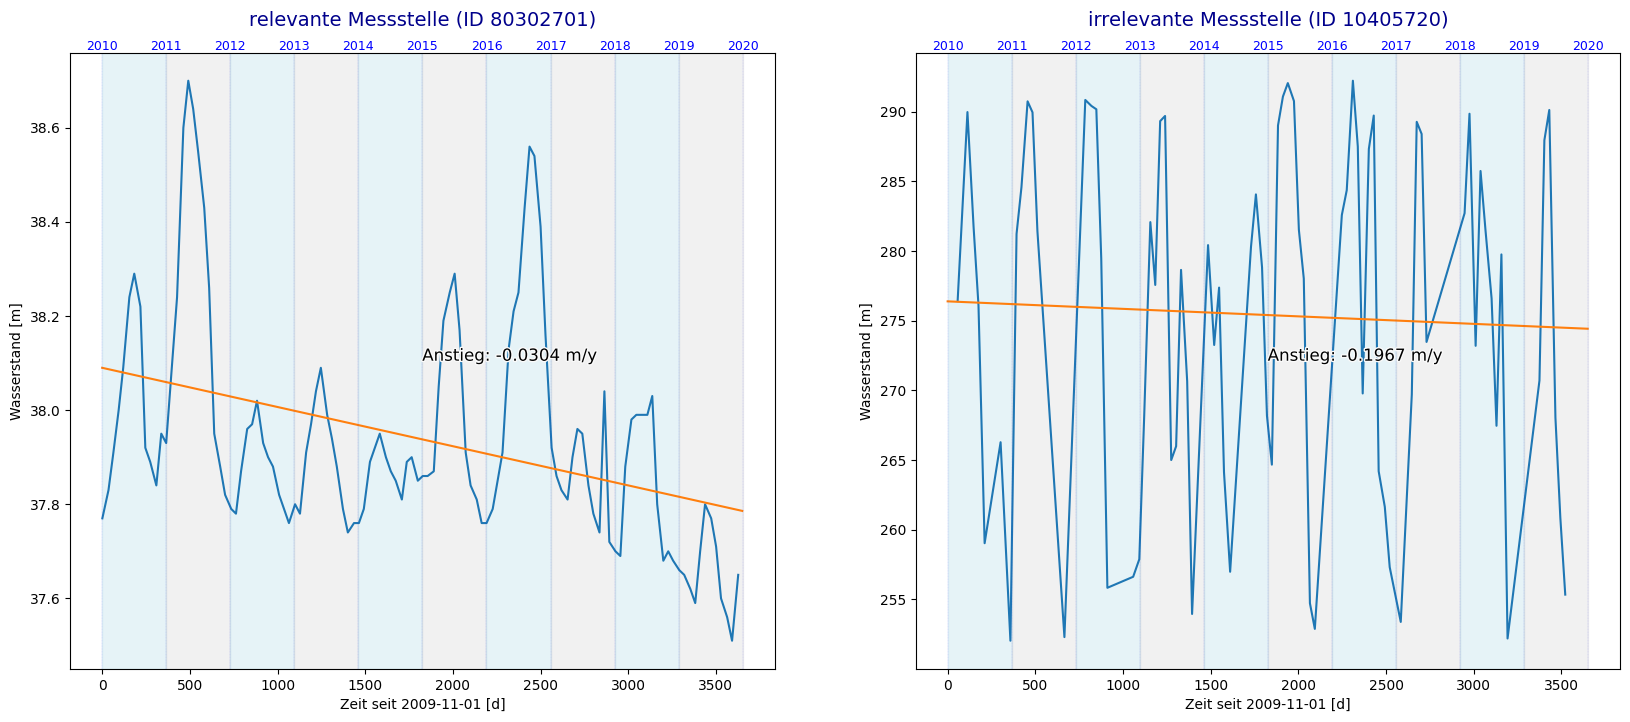

In [130]:
# Startdatum
tage_pro_jahr = 365.25 # Mit Schaltjahr
startjahr = 2010 # Kalendarisches Datum
t0 = pd.Timestamp("2009-11-01") # Beginn des Wasserwirtschaftsjahr 2010

random_relevant_ms = random.choice(mess_id_in_relevant)
random_irrelevant_ms = random.choice(mess_id_in_irrelevant)

df_relevant_ms = (
        df_ms_ws_input
        .loc[df_ms_ws_input.loc[:, 'messstelle_id'] == random_relevant_ms]
        .sort_values('datum_messung')
        .copy()
        )

df_irrelevant_ms = (
        df_ms_ws_input
        .loc[df_ms_ws_input.loc[:, 'messstelle_id'] == random_irrelevant_ms]
        .sort_values('datum_messung')
        .copy()
        )

df_relevant_ms["t"] = (df_relevant_ms["datum_messung"] - t0).dt.days
df_irrelevant_ms["t"] = (df_irrelevant_ms["datum_messung"] - t0).dt.days

# Lineare Regression
model_relevant_ms = smf.ols(formula='wasserstd_m ~ t', data=df_relevant_ms)
results_relevant_ms = model_relevant_ms.fit()

model_irrelevant_ms = smf.ols(formula='wasserstd_m ~ t', data=df_irrelevant_ms)
results_irrelevant_ms = model_irrelevant_ms.fit()

# Plotten zufällig ausgewählter Grundwasserpegel
fig, ax = plt.subplots(figsize=[20, 8], nrows=1, ncols=2)

# Regressionslinien
df_relevant_ms.plot(kind='line', x='t', y='wasserstd_m', ax=ax[0], legend=False);
df_irrelevant_ms.plot(kind='line', x='t', y='wasserstd_m', ax=ax[1], legend=False);

(results_relevant_ms.predict(pd.DataFrame({"t": range(3651)}))).plot(ax=ax[0])
(results_irrelevant_ms.predict(pd.DataFrame({"t": range(3651)}))).plot(ax=ax[1])

ax[0].set_title(f"relevante Messstelle (ID {random_relevant_ms})", fontsize=14, color="darkblue", pad=20)
ax[1].set_title(f"irrelevante Messstelle (ID {random_irrelevant_ms})", fontsize=14, color="darkblue", pad=20)
ax[0].set_xlabel(f"Zeit seit {t0.strftime("%Y-%m-%d")} [d]")
ax[1].set_xlabel(f"Zeit seit {t0.strftime("%Y-%m-%d")} [d]")
ax[0].set_ylabel("Wasserstand [m]")
ax[1].set_ylabel("Wasserstand [m]")

ax[0].text(x=sum(ax[0].get_xlim()) / 2, y=sum(ax[0].get_ylim()) / 2,
           s=f"Anstieg: {results_relevant_ms.params["t"] * 365.25:.4f} m/y",
           path_effects=[path_effects.Stroke(linewidth=2, foreground='#FAFAFA'), path_effects.Normal()],
           fontsize=12)
ax[1].text(x=sum(ax[1].get_xlim()) / 2, y=sum(ax[1].get_ylim()) / 2,
           s=f"Anstieg: {results_irrelevant_ms.params["t"] * 365.25:.4f} m/y",
           path_effects=[path_effects.Stroke(linewidth=2, foreground='#FAFAFA'), path_effects.Normal()],
           fontsize=12)

for count in range(2):
    for jahr in range(10):
        start = jahr * tage_pro_jahr
        ende = (jahr + 1) * tage_pro_jahr

        ax[count].axvspan(start, ende, 
                color=("lightblue" if jahr % 2 == 0 else "lightgray"),
                alpha=0.3)

    for jahr in range(11):   # 10 Jahre = 11 Marken
        x_pos = jahr * tage_pro_jahr
        ax[count].axvline(x=x_pos, color="blue", linestyle=":", alpha=0.7, linewidth=0.2)
        ax[count].text(
            x_pos,                          # x-Position
            ax[count].get_ylim()[1],        # y-Position (oben)
            str(startjahr + jahr),          # Text
            ha="center", va="bottom",       # horizontale/vertikale Ausrichtung
            fontsize=9, color="blue"
        )


In [131]:
df_irrelevant_ms.head(3)

,messstelle_id,name,e32,n32,turnus_wasserstand,freigabe_wstd,freigabe_chemie,freigabe_lage,messstellenart,datum_messung,abstich_m,hinweis,wasserstd_m,flurabstd_m,mph_m,gok_m,wwj,t
567059,10405720,STAWAG Schmith.5/92,299851,5619653,monatlich,ja,nein,ja,GW-Messstelle,2009-12-28,24.77,-,276.410004,24.889999,301.179993,301.299988,2010,57
567060,10405720,STAWAG Schmith.5/92,299851,5619653,monatlich,ja,nein,ja,GW-Messstelle,2010-01-25,17.98,-,283.200012,18.100000,301.179993,301.299988,2010,85
567061,10405720,STAWAG Schmith.5/92,299851,5619653,monatlich,ja,nein,ja,GW-Messstelle,2010-02-22,11.20,-,289.980011,11.320000,301.179993,301.299988,2010,113


<Axes: >

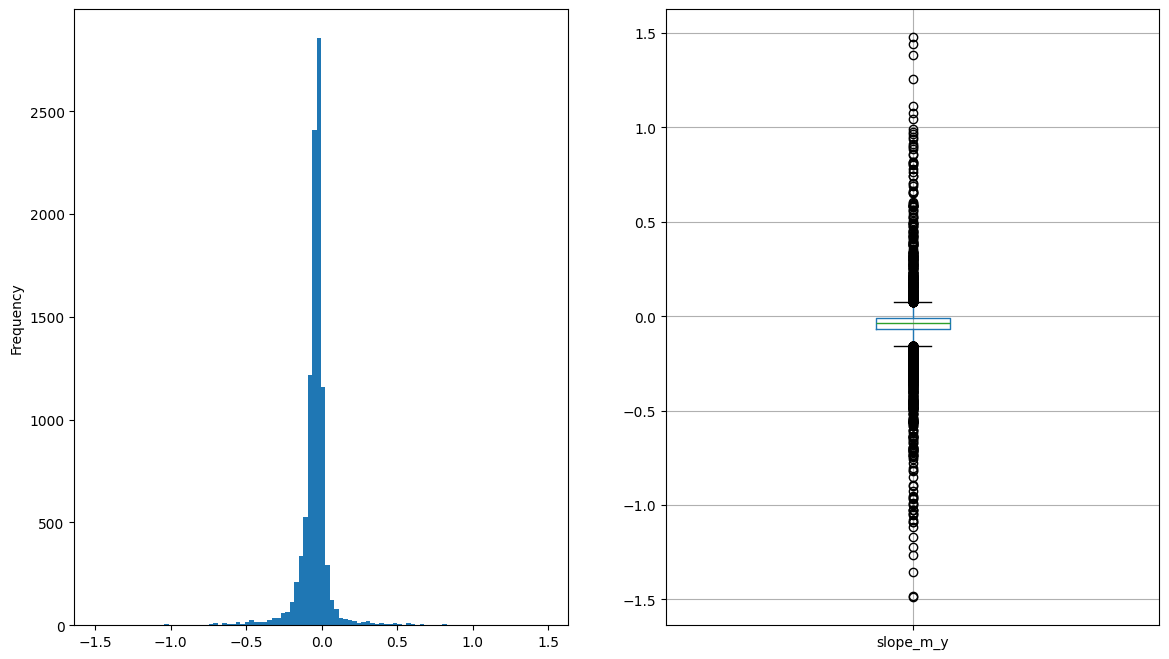

In [132]:
fig, ax = plt.subplots(figsize=[14, 8], nrows=1, ncols=2)

df_mess_id_relevant['slope_m_y'].plot(kind='hist', bins=100, ax=ax[0]);

df_mess_id_relevant.boxplot(
    column="slope_m_y",
    # by="senkung",
    grid=True,
    ax=ax[1]
)

*Statistik des Grundwasseranstieges*


In [133]:
df_mess_id_relevant["slope_m_y"].describe()

count    9958.000000
mean       -0.047457
std         0.125455
min        -1.488518
25%        -0.069720
50%        -0.036857
75%        -0.012305
max         1.478314
Name: slope_m_y, dtype: float64

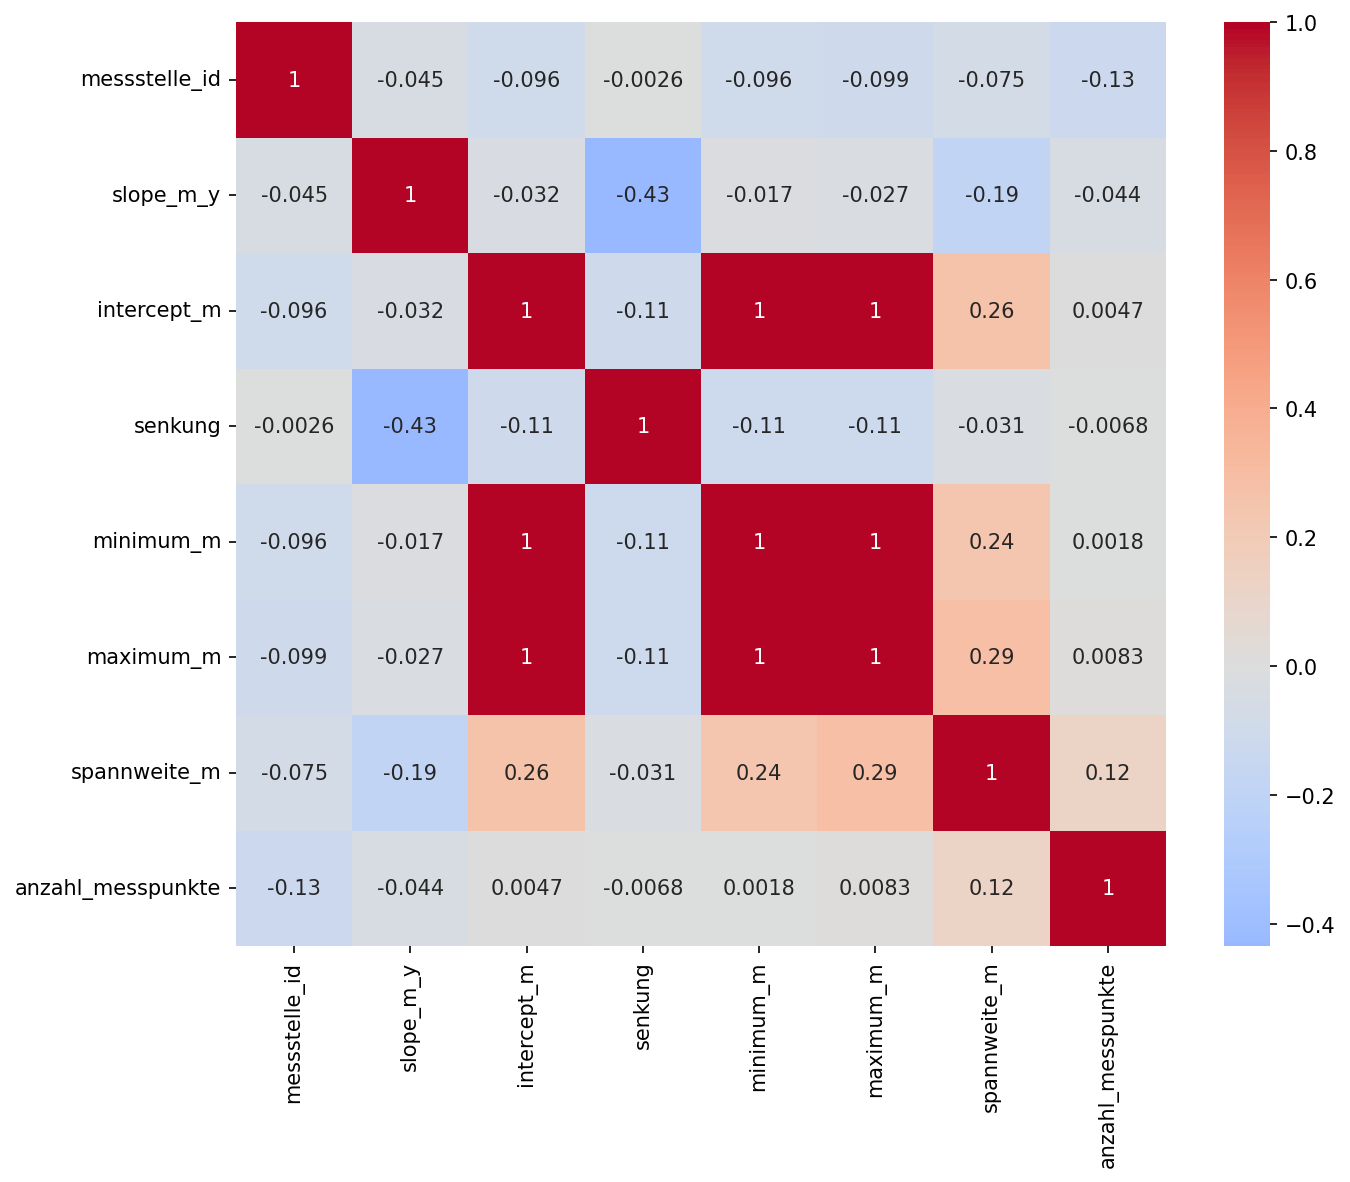

In [134]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=150)

sns.heatmap(df_mess_id_relevant.corr(numeric_only=True), annot=True, cmap="coolwarm", center=0, ax=ax);

KeyboardInterrupt: 

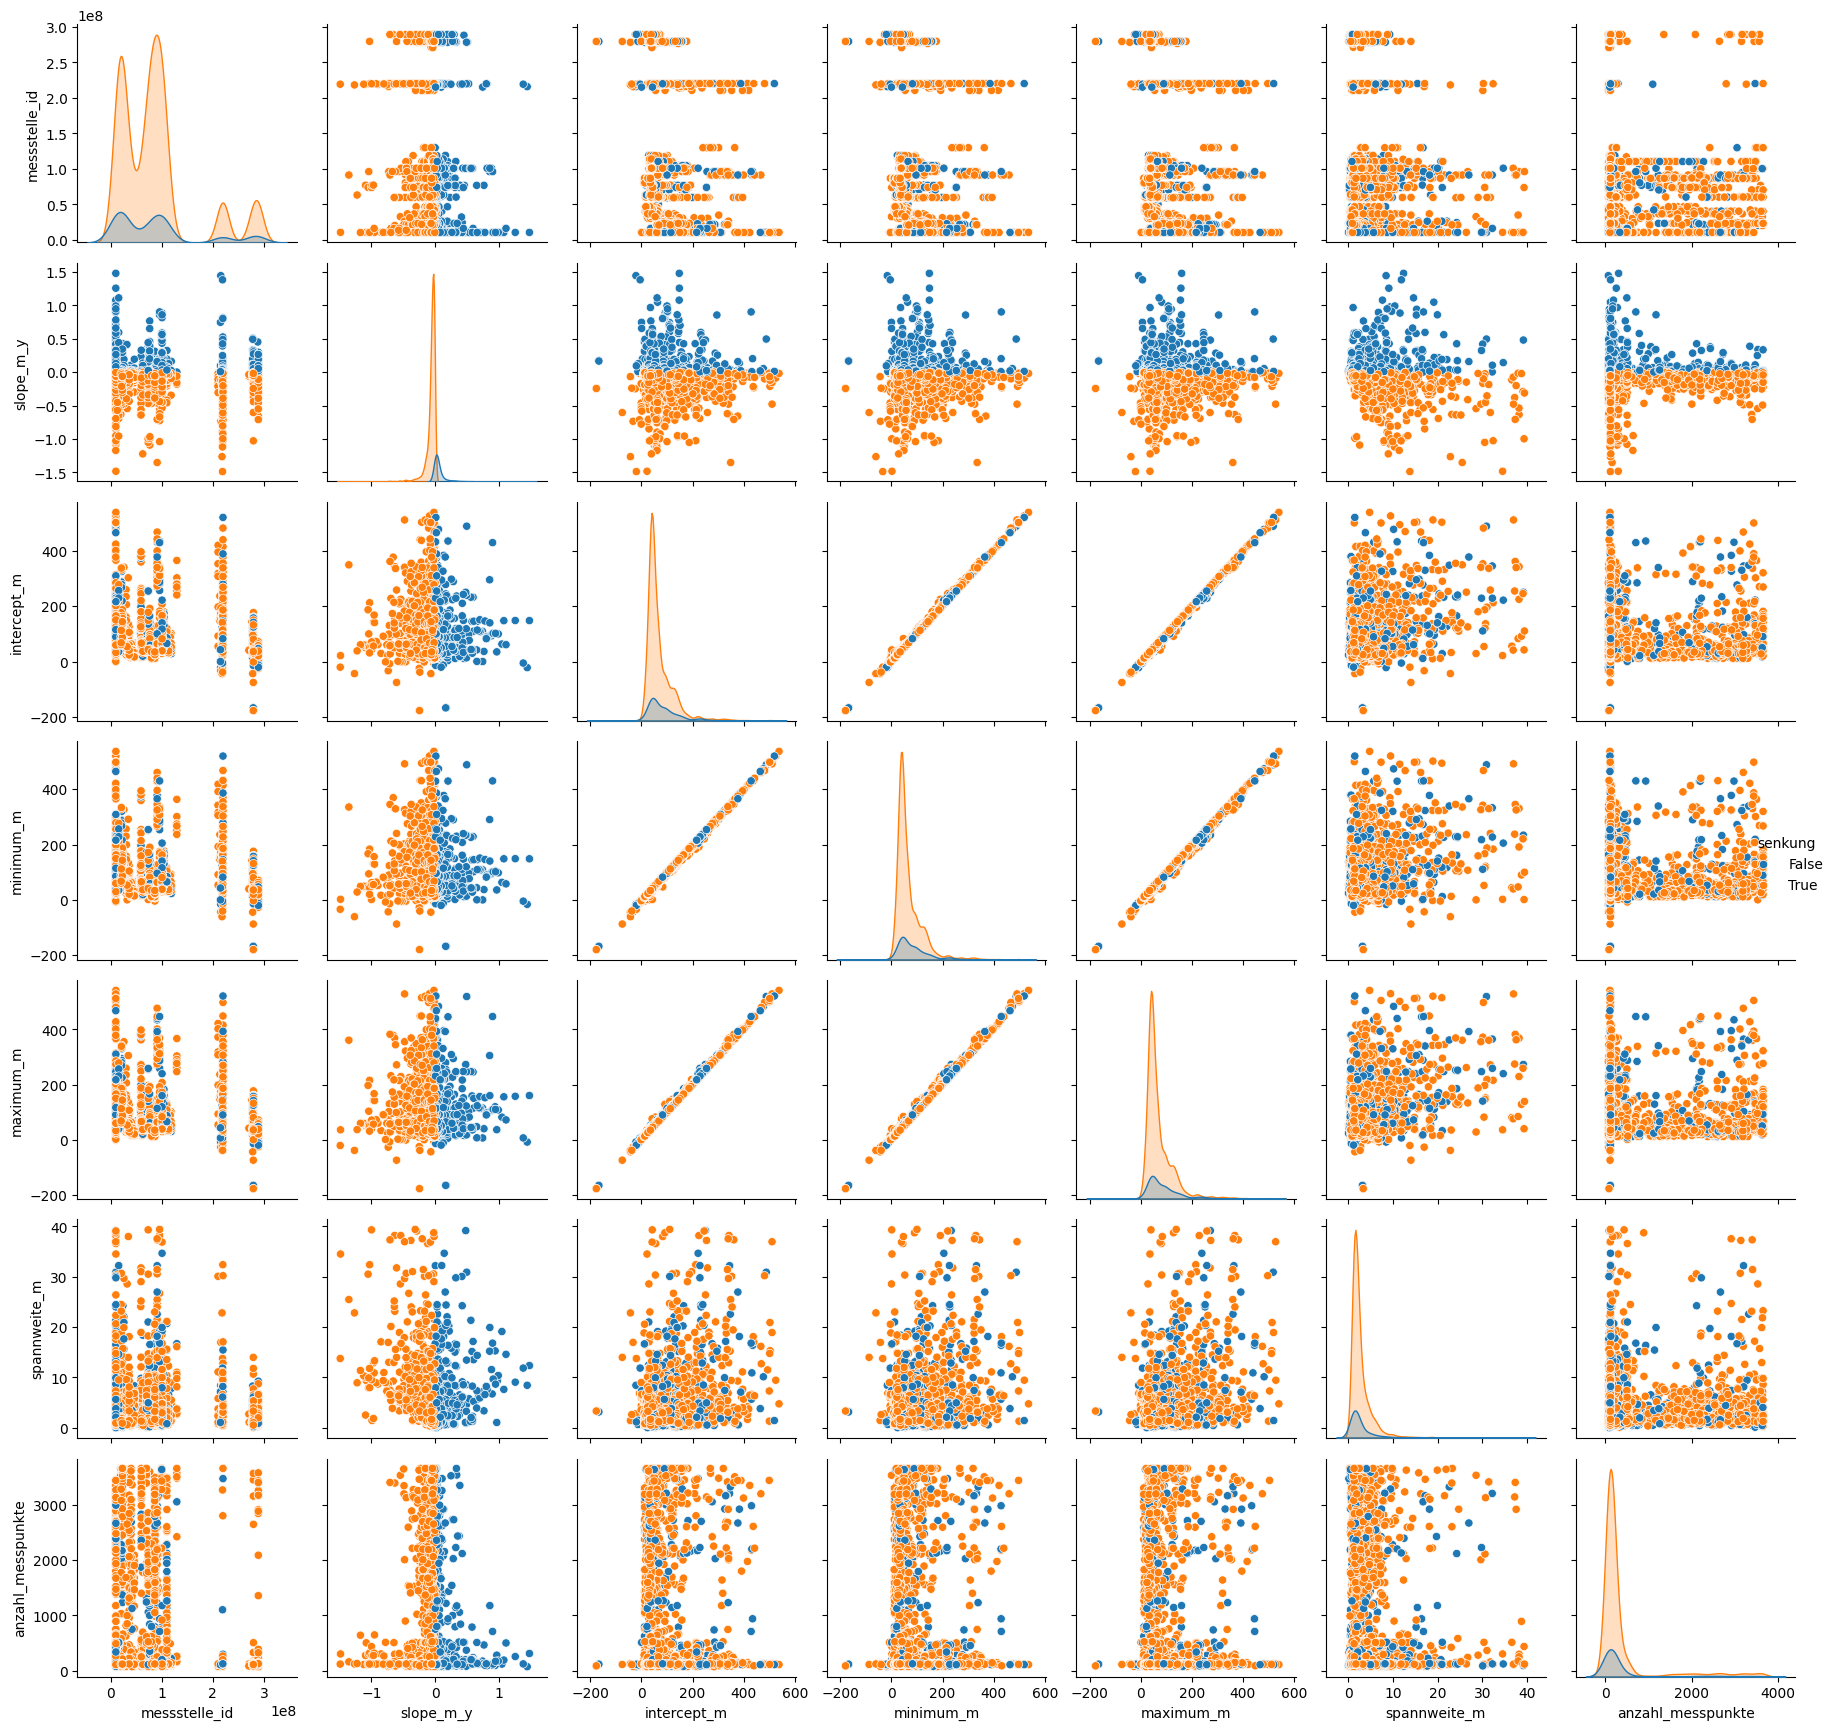

In [135]:
sns.pairplot(data=df_mess_id_relevant, hue='senkung');

In [ ]:
df_mess_id_relevant["slope_klasse"] = pd.cut(
    df_mess_id_relevant["slope_m_y"],
    bins=[-1.5, -0.5, -0.1, 0.1, 0.5, 1.5],
    labels=[1, 2, 3, 4, 5],
    include_lowest=True
)

In [ ]:
df_mess_id_relevant.head()

,messstelle_id,slope_m_y,intercept_m,senkung,minimum_m,maximum_m,spannweite_m,anzahl_messpunkte,slope_klasse
0,70283916,0.067013,157.766118,False,157.389999,159.130005,1.740005,137,3
1,10445730,-0.179650,31.210349,True,26.799999,30.820000,4.020000,2250,2
2,10445791,-0.062256,31.152236,True,30.170000,31.610001,1.440001,2207,3
3,10446722,0.075724,80.778631,False,80.760002,81.589996,0.829994,1705,3
4,100151115,0.015632,39.662841,False,38.310001,40.500000,2.189999,120,3


In [ ]:
print(df_mess_id_relevant["slope_klasse"].value_counts(normalize=False).sort_index())
print(df_mess_id_relevant["slope_klasse"].value_counts(normalize=True).sort_index() * 100)

slope_klasse
1      92
2    1361
3    8226
4     227
5      52
Name: count, dtype: int64
slope_klasse
1     0.923880
2    13.667403
3    82.606949
4     2.279574
5     0.522193
Name: proportion, dtype: float64


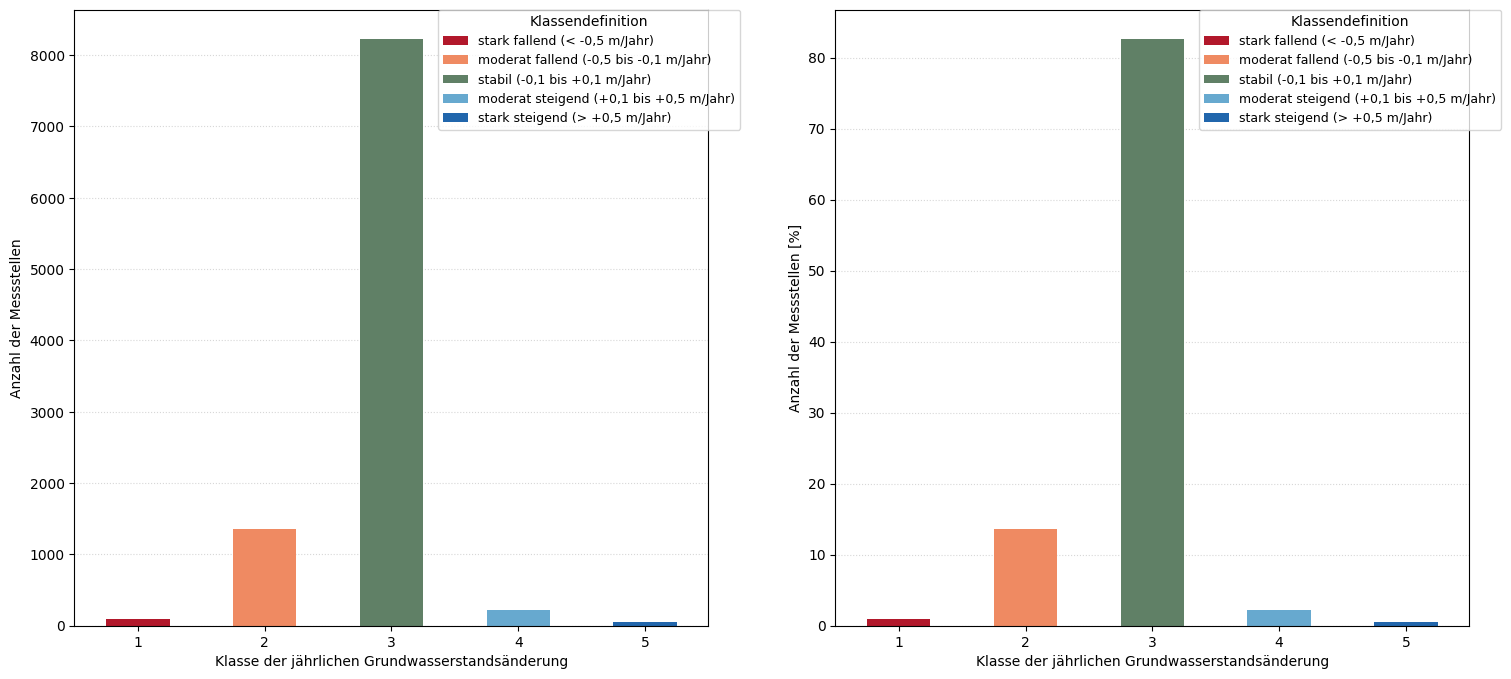

In [ ]:
farbklassen = {
    1: {"farbe": "#b2182b", "label": "stark fallend (< -0,5 m/Jahr)"},
    2: {"farbe": "#ef8a62", "label": "moderat fallend (-0,5 bis -0,1 m/Jahr)"},
    3: {"farbe": "#608066", "label": "stabil (-0,1 bis +0,1 m/Jahr)"},
    4: {"farbe": "#67a9cf", "label": "moderat steigend (+0,1 bis +0,5 m/Jahr)"},
    5: {"farbe": "#2166ac", "label": "stark steigend (> +0,5 m/Jahr)"},
}

counts = (
    df_mess_id_relevant["slope_klasse"]
    .astype("Int64")
    .value_counts()
    .reindex(farbklassen.keys(), fill_value=0)
)

farben_liste = [farbklassen[k]["farbe"] for k in counts.index]

fig, ax = plt.subplots(figsize=[18, 8], nrows=1, ncols=2)

df_mess_id_relevant.loc[:,'slope_klasse'].value_counts(normalize=False).sort_index().plot(kind='bar', ax=ax[0], color=farben_liste)
df_mess_id_relevant.loc[:,'slope_klasse'].value_counts(normalize=True).sort_index().mul(100).plot(kind='bar', ax=ax[1], color=farben_liste)


for axes in range(2):

    handles = [
    Patch(
        facecolor=patch.get_facecolor(),
        label=farbklassen[i]['label']
    )
    for i, patch in zip(counts.index, ax[axes].patches)
    ]
    
    ax[axes].grid(True, linestyle=':', alpha=0.5, axis='y')
    ax[axes].set_axisbelow(True)
    ax[axes].set_xlabel('Klasse der jährlichen Grundwasserstandsänderung', fontsize=10)
    ax[axes].set_xticklabels(['1', '2', '3', '4', '5'], rotation=0);
    
    if axes == 0:
        ax[axes].set_ylabel('Anzahl der Messstellen', fontsize=10)
    if axes == 1:
        ax[axes].set_ylabel('Anzahl der Messstellen [%]', fontsize=10)

    ax[axes].legend(
        handles=handles,
        title="Klassendefinition",
        loc="upper right",
        fontsize=9,
        bbox_to_anchor=(1.05, 1),
        borderaxespad=0
    )


In [ ]:
counts

slope_klasse
1      92
2    1361
3    8226
4     227
5      52
Name: count, dtype: Int64

Aufbereitung der Ergebnisse für QGIS

In [153]:
# Einlesen der Grundwasser-Messstellen im Pickle-Format
df_ms = pd.read_pickle("../data/processed/grundwasserdaten-NRW/GW-Messtellen.pkl")

df_ms_ws_gis = pd.merge(
    df_ms,
    df_mess_id_relevant,
    on="messstelle_id",
    how="inner"
)

df_ms_ws_gis.head()

,messstelle_id,name,e32,n32,turnus_wasserstand,freigabe_wstd,freigabe_chemie,freigabe_lage,messstellenart,slope_m_y,intercept_m,senkung,minimum_m,maximum_m,spannweite_m,anzahl_messpunkte,slope_klasse
0,70283916,LGD BN KOTTENF. 3,362354,5615873,monatlich,ja,ja,ja,GW-Messstelle,0.067013,157.766118,False,157.389999,159.130005,1.740005,137,3
1,10445730,60BP010505,2911XX,56692XX,vierzehntäglich,ja,nein,nein,GW-Messstelle,-0.179650,31.210349,True,26.799999,30.820000,4.020000,2250,2
2,10445791,60BP010701,2908XX,56657XX,vierzehntäglich,ja,nein,nein,GW-Messstelle,-0.062256,31.152236,True,30.170000,31.610001,1.440001,2207,3
3,10446722,60GP012301,2920XX,56453XX,monatlich,ja,nein,nein,GW-Messstelle,0.075724,80.778631,False,80.760002,81.589996,0.829994,1705,3
4,100151115,WE 33 WEHE,4787XX,58085XX,monatlich,ja,nein,nein,GW-Messstelle,0.015632,39.662841,False,38.310001,40.500000,2.189999,120,3


In [158]:
for index in df_ms_ws_gis.index:
    if df_ms_ws_gis.loc[index, 'freigabe_lage'] == 'nein':
        df_ms_ws_gis.loc[index, 'e32'] = df_ms_ws_gis.loc[index, 'e32'].replace("XX", "50")
        df_ms_ws_gis.loc[index, 'n32'] = df_ms_ws_gis.loc[index, 'n32'].replace("XX", "50")
        
df_ms_ws_gis.head()


,messstelle_id,name,e32,n32,turnus_wasserstand,freigabe_wstd,freigabe_chemie,freigabe_lage,messstellenart,slope_m_y,intercept_m,senkung,minimum_m,maximum_m,spannweite_m,anzahl_messpunkte,slope_klasse
0,70283916,LGD BN KOTTENF. 3,362354,5615873,monatlich,ja,ja,ja,GW-Messstelle,0.067013,157.766118,False,157.389999,159.130005,1.740005,137,3
1,10445730,60BP010505,291150,5669250,vierzehntäglich,ja,nein,nein,GW-Messstelle,-0.179650,31.210349,True,26.799999,30.820000,4.020000,2250,2
2,10445791,60BP010701,290850,5665750,vierzehntäglich,ja,nein,nein,GW-Messstelle,-0.062256,31.152236,True,30.170000,31.610001,1.440001,2207,3
3,10446722,60GP012301,292050,5645350,monatlich,ja,nein,nein,GW-Messstelle,0.075724,80.778631,False,80.760002,81.589996,0.829994,1705,3
4,100151115,WE 33 WEHE,478750,5808550,monatlich,ja,nein,nein,GW-Messstelle,0.015632,39.662841,False,38.310001,40.500000,2.189999,120,3


In [155]:
df_ms_ws_gis.to_csv("../data/processed/grundwasserdaten-NRW/GW-MessWasserstellenGIS.csv")